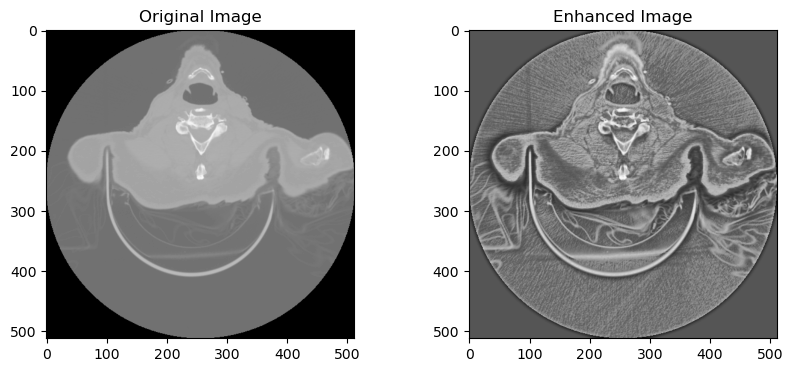

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # For plotting
import SimpleITK as sitk  # For loading and preprocessing the image
import ipywidgets as widgets  # For providing widgets for interactive visualization
from IPython.display import display  # For displaying widgets
import os
import numpy as np

# Function to load DICOM series and create a 3D image
def load_dicom_series(directory, file_prefix, num_files):
    file_names = [os.path.join(directory, f"{file_prefix}{str(i).zfill(3)}.dcm") for i in range(1, num_files + 1)]
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(file_names)
    img_T1 = reader.Execute()
    return img_T1

# Load the DICOM series
directory = 'dicom'  # Path to the DICOM files
file_prefix = '1-'  # Prefix of the DICOM files
num_files = 10 # change number of files AS NEEDED (VERY SLOW ON 10)
img_T1 = load_dicom_series(directory, file_prefix, num_files)

img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)  # Rescale intensities from [0,1] to [0,255]

# Preprocessing
img_T1_enhanced = sitk.AdaptiveHistogramEqualization(img_T1)   # Contrast enhancement
img_T1_255_enhanced = sitk.Cast(sitk.RescaleIntensity(img_T1_enhanced), sitk.sitkUInt8)  # Rescale intensities from [0,1] to [0,255]

# Display the original and enhanced images
plt.figure(figsize=(10, 4)) # Set the figure size
plt.subplot(1, 2, 1) # Set the number of rows, columns and the index of the subfigure
plt.imshow(sitk.GetArrayFromImage(img_T1_255)[0], cmap='gray')  # Adjust the slice index if needed
plt.title('Original Image') # Set the title of the subfigure
plt.subplot(1, 2, 2) 
plt.imshow(sitk.GetArrayFromImage(img_T1_255_enhanced)[0], cmap='gray')
plt.title('Enhanced Image')
plt.show()

In [2]:
img_T1.GetSize() # Get image size

(512, 512, 10)

In [3]:
# setting size of the image
size = img_T1.GetSize()

# Define sliders
x_slider = widgets.IntSlider(min=0, max=size[0]-1, value=size[0]//2, description='X:') # slider for x coordinate of the seed point
y_slider = widgets.IntSlider(min=0, max=size[1]-1, value=size[1]//2, description='Y:') # slider for y coordinate of the seed point
z_slider = widgets.IntSlider(min=0, max=size[2]-1, value=size[2]//2, description='Z:') # slider for z coordinate of the seed point
radius_x_slider = widgets.IntSlider(min=0, max=size[0]//2, value=3, description='Radius X:') # slider for radius in x direction
radius_y_slider = widgets.IntSlider(min=0, max=size[1]//2, value=3, description='Radius Y:') # slider for radius in y direction
radius_z_slider = widgets.IntSlider(min=0, max=size[2]//2, value=3, description='Radius Z:') # slider for radius in z direction


@widgets.interact(x=x_slider, y=y_slider, z=z_slider,
                  radius_x=radius_x_slider, radius_y=radius_y_slider, radius_z=radius_z_slider) # Define the interactive function

# Seed point selection function
def update_seed_point(x, y, z, radius_x, radius_y, radius_z):
    global seg, init_ls, idx  
    idx = (x, y, z)  # Store the current slice index

    # Create an initial segmentation with the specified radius
    seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
    seg.CopyInformation(img_T1)  # Copy the metadata from the original image
    for dx in range(-radius_x, radius_x+1):  # Set the pixels inside the sphere to 1
        for dy in range(-radius_y, radius_y+1): # same as above
            for dz in range(-radius_z, radius_z+1): # same as above
                if len(size) > 2:  # For 3D images 
                    seg[min(max(x+dx, 0), size[0]-1),  # Make sure the coordinates are inside the image
                        min(max(y+dy, 0), size[1]-1),  # same as above
                        min(max(z+dz, 0), size[2]-1)] = 1 # same as above
                else:  # For 2D images
                    seg[min(max(x+dx, 0), size[0]-1), 
                        min(max(y+dy, 0), size[1]-1)] = 1

    # Display the seed point and radius on the original and enhanced images
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(sitk.GetArrayFromImage(sitk.LabelOverlay(img_T1_255, seg))[idx[2]], cmap='gray')
    plt.title('Seed on Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(sitk.GetArrayFromImage(sitk.LabelOverlay(img_T1_255_enhanced, seg))[idx[2]], cmap='gray')
    plt.title('Seed on Enhanced Image')
    plt.show()

interactive(children=(IntSlider(value=256, description='X:', max=511), IntSlider(value=256, description='Y:', …

In [4]:
factor_slider = widgets.FloatSlider(value=1.5, min=0.5, max=3.0, step=0.1, description='Factor:')  # Define the slider for factor parameter of the initial level set function
rms_error_slider = widgets.FloatSlider(value=0.02, min=0.01, max=0.1, step=0.01, description='RMS Error:')  # Define the slider for RMS error parameter of the initial level set function
iterations_slider = widgets.IntSlider(value=100, min=50, max=500, step=50, description='Iterations:') # Define the slider for number of iterations of the initial level set function

In [5]:
# Prepare for level set segmentation
stats = sitk.LabelStatisticsImageFilter() # Create a filter for computing statistics of the image
stats.Execute(img_T1_enhanced, seg) # Compute the statistics of the image inside the segmentation
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True) # Compute the initial level set function

# Define the update for the initial level set function
def update_segmentation(factor, rms_error, iterations):
    lower_threshold = stats.GetMean(1) - factor * stats.GetSigma(1) # Compute the lower threshold for the level set function
    upper_threshold = stats.GetMean(1) + factor * stats.GetSigma(1) # Compute the upper threshold for the level set function
    
    lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter() # Create a filter for level set segmentation
    lsFilter.SetLowerThreshold(lower_threshold) # Set the lower threshold
    lsFilter.SetUpperThreshold(upper_threshold) # Set the upper threshold
    lsFilter.SetMaximumRMSError(rms_error) # Set the RMS error
    lsFilter.SetNumberOfIterations(iterations) # Set the number of iterations
    lsFilter.SetCurvatureScaling(1) # Set the curvature scaling
    lsFilter.SetPropagationScaling(1) # Set the propagation scaling
    lsFilter.ReverseExpansionDirectionOn() # Reverse the direction of the level set function evolution

    ls = lsFilter.Execute(init_ls, sitk.Cast(img_T1_enhanced, sitk.sitkFloat32)) # Compute the level set function

# Display the updated segmentation result
    plt.imshow(sitk.GetArrayFromImage(sitk.LabelOverlay(img_T1_255_enhanced, ls > 0))[idx[2]], cmap='gray') 
    plt.title('Segmented Image')
    plt.show()


In [6]:
interactive_plot = widgets.interactive(update_segmentation, 
                                       factor=factor_slider, 
                                       rms_error=rms_error_slider, 
                                       iterations=iterations_slider)  # Define the interactive plot
display(interactive_plot) # Display the interactive plot


interactive(children=(FloatSlider(value=1.5, description='Factor:', max=3.0, min=0.5), FloatSlider(value=0.02,…

Iteration 25, RMS Change: 0.024472455288761373


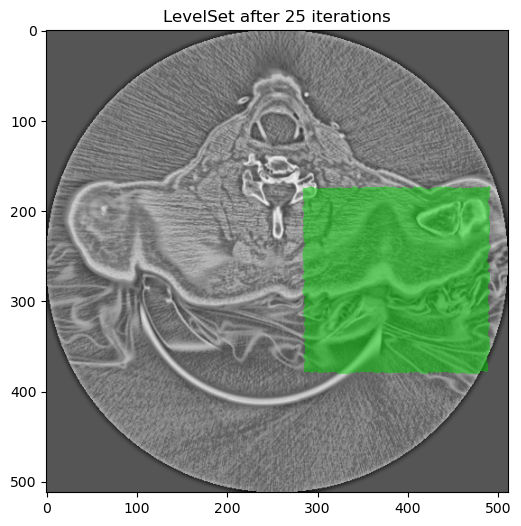

Iteration 50, RMS Change: 0.02626881859922369


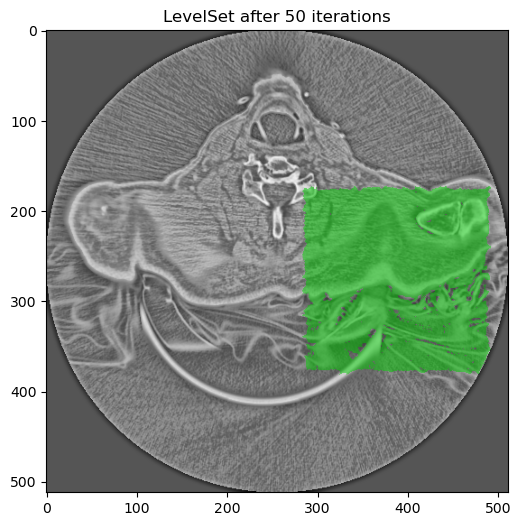

Iteration 75, RMS Change: 0.025775422490652265


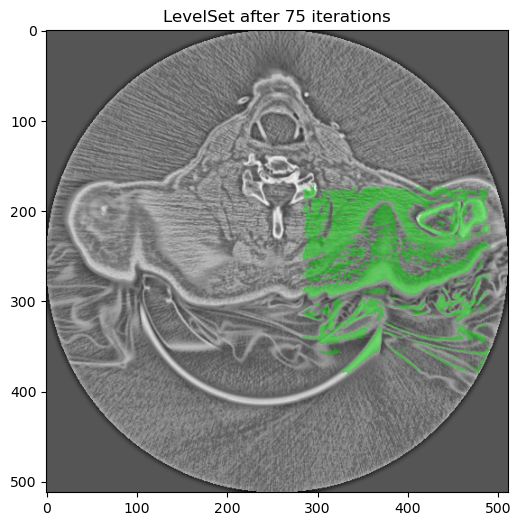

Iteration 100, RMS Change: 0.021216555391709198


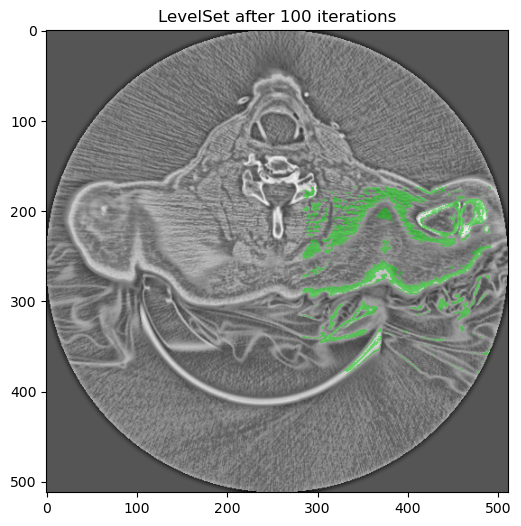

Iteration 125, RMS Change: 0.019669408462593966


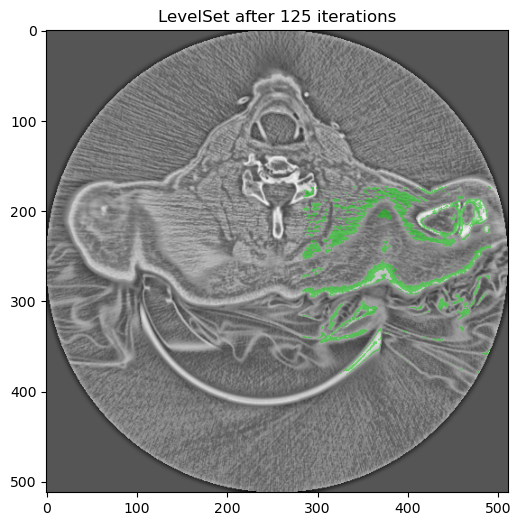

Iteration 150, RMS Change: 0.018780078920008936


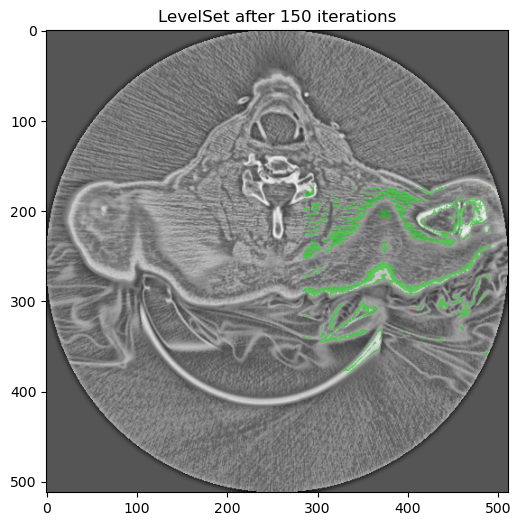

Iteration 175, RMS Change: 0.018159830974604132


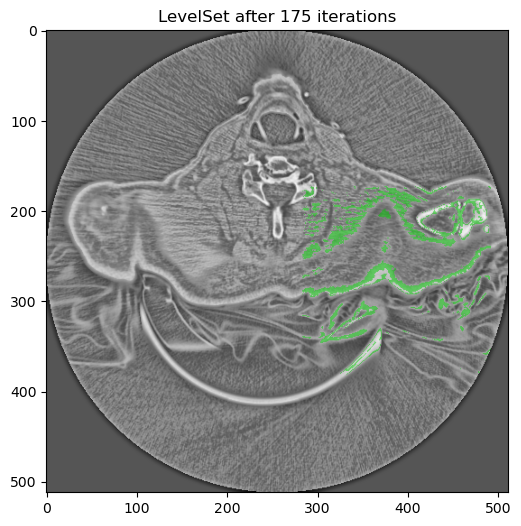

Iteration 200, RMS Change: 0.017438776628572576


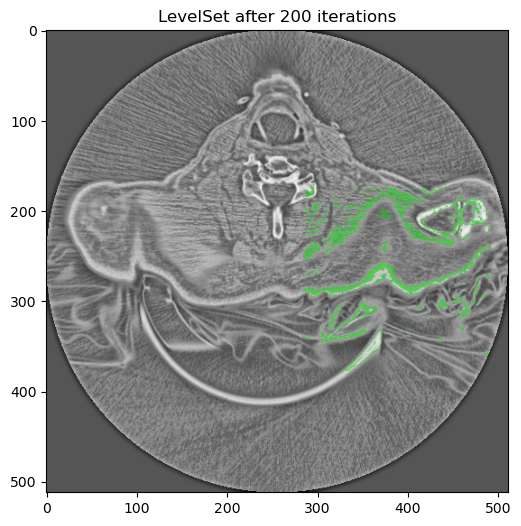

Iteration 225, RMS Change: 0.01725232760264693


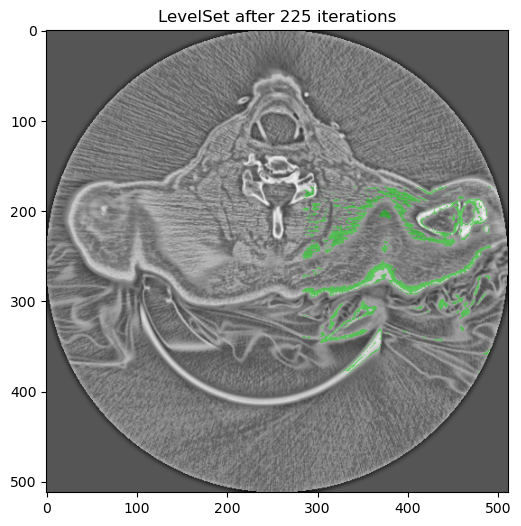

Iteration 250, RMS Change: 0.017789958386191945


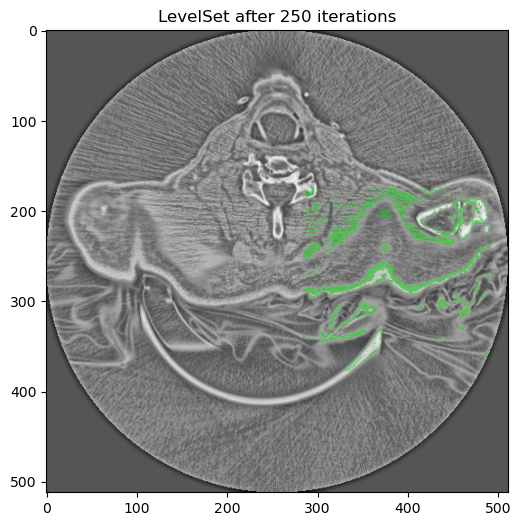

In [7]:
# Define the function for iterative level set segmentation
def perform_iterative_level_set(init_ls, img_T1f, num_outer_iterations=10, num_inner_iterations=25):
    lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter() # Create a filter for level set segmentation
    lsFilter.SetNumberOfIterations(num_inner_iterations) # Set the number of iterations
    lsFilter.SetCurvatureScaling(1) # Set the curvature scaling
    lsFilter.SetPropagationScaling(1) # Set the propagation scaling
    lsFilter.ReverseExpansionDirectionOn() # Reverse the direction of the level set function evolution

    ls = init_ls # Set the initial level set function
    niter = 0 # Initialize the number of iterations
    
    for i in range(num_outer_iterations): # Iterate over the number of outer iterations
        ls = lsFilter.Execute(ls, img_T1f) # Compute the level set function
        niter += lsFilter.GetNumberOfIterations() # Update the number of iterations
        print(f"Iteration {niter}, RMS Change: {lsFilter.GetRMSChange()}") # Print the number of iterations and the RMS change

        # Display for the current iteration
        plt.figure(figsize=(6, 6))
        plt.imshow(sitk.GetArrayFromImage(sitk.LabelOverlay(img_T1_255_enhanced, ls > 0))[idx[2]], cmap='gray')
        plt.title(f"LevelSet after {niter} iterations")
        plt.show()

# Call the function with the initial level set and the enhanced image
perform_iterative_level_set(init_ls, sitk.Cast(img_T1_enhanced, sitk.sitkFloat32))
